# Probabilistic Graphical Models, SS 2022

In [1]:
import os
import re
import nltk
import shutil
import gensim
import pprint
import random
import zipfile
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from gensim.corpora import Dictionary
from sklearn.datasets import load_files
from nltk.corpus import names, stopwords
from gensim.models.phrases import Phraser
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from gensim.models import Phrases, CoherenceModel, LdaModel, HdpModel

stop_words = stopwords.words('english')

## 1. Loading and preprocessing the datasets

### 1.1 Load `20NewsGroup` dataset

In [2]:
ARCHIVE_NAME_ORIGINAL = "original.zip"
ARCHIVE_NAME_MODIFIED = "modified.zip"

In [3]:
def load_dataset(archive_name):
    target_dir = 'data/'
    archive_path = os.path.join(target_dir, archive_name)
    if archive_name=="original.zip":        
        path = os.path.join(target_dir, 'original')
    else:
        path = os.path.join(target_dir, 'modified')
       
    print("Decompressing %s" %archive_name)    
    with zipfile.ZipFile(archive_path, 'r') as zip_ref:
        if not os.path.exists(path):
            zip_ref.extractall(target_dir)
        else:
            shutil.rmtree(path)
            zip_ref.extractall(target_dir) 
    
    # Load text files with categories as subfolder names
    # Decode text files, if encoding=None load_files() returns list of bytes
    dataset = load_files(path, load_content=True, encoding='latin1')
    data = dataset.data
    print("Data is decompressed!") 
    
    return data

#### Load '20NewsGroup' dataset in two formats: the original (orig), and a slightly modified (mod) version

In [4]:
nltk.download('wordnet')
nltk.download('omw-1.4')

dataset_original = load_dataset(ARCHIVE_NAME_ORIGINAL)
print('Number of original newsgroup documents: %d\n' % len(dataset_original))

dataset_modified = load_dataset(ARCHIVE_NAME_MODIFIED)
print('Number of modified newsgroup documents: %d' % len(dataset_modified))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Decompressing original.zip
Data is decompressed!
Number of original newsgroup documents: 19997

Decompressing modified.zip
Data is decompressed!
Number of modified newsgroup documents: 18397


### 1.2 Preprocess the datasets

In [5]:
#remove the documents' header
#def remove_text_header(text):
 #   header, blankline, content = text.partition('\n\n')
  #  return content

#remove the documents' footer/signature
#def remove_text_footer(text):
 #   text = text.replace('-', '')        
  #  content, blankline, footer = text.rpartition('\n\n')
   # return content

In [6]:
def preprocess(dataset):  
    min_tokens = 25
    
    # remove document with fewer than 25 tokens
    dataset = [paper for paper in dataset if len(paper.split())>min_tokens]
    
    # remove emails
    dataset = [re.sub('\S*@\S*\s?', '', paper) for paper in dataset] 
        
    # convert to lowercase and split document into tokens
    for i in tqdm(range(len(dataset))):
        # remove punctuation, numbers and tokens that contain numbers
        tokenizer = RegexpTokenizer(r'[a-zA-Z]{3,}') # r'\w+'
        dataset[i] = dataset[i].lower()
        dataset[i] = tokenizer.tokenize(dataset[i]) 
    
    #remove numbers but not words that contains numbers
    #data = [[token for token in paper if not token.isnumeric()] for paper in dataset]

    # remove tokens with less than three-character string
    #dataset = [[token for token in paper if len(token)>2] for paper in dataset]
    
    # remove stop words
    stop_words.extend(['from','subject','re','edu','use','cmu'])
    dataset = [[token for token in paper if token not in stop_words] for paper in dataset]
    
    # add bigrams to docs (only ones that appear 20 times or more, 
    # with the score of the phrase greater than threshold)
    bigram = Phrases(dataset, min_count=20, scoring='npmi', threshold=0.8)
    bigram_mod = Phraser(bigram)
    dataset = [bigram_mod[paper] for paper in dataset]
    
    #map pos_tag to first character lemmatize() accepts
    #tags = lambda e: ('a' if e[0].lower() == 'j' else e[0].lower()) if e[0].lower() in ['n', 'r', 'v'] else 'n'
    #tags(nltk.pos_tag([token])[0][1][0])

    lemmatizer = WordNetLemmatizer()
    
    # lemmatize with corresponding pos_tag: NOUN='n', VERB='v'
    dataset = [[lemmatizer.lemmatize(token, 'v') for token in paper] for paper in dataset]
    dataset = [[lemmatizer.lemmatize(token, 'n') for token in paper] for paper in dataset]
        
    # create vocabulary
    dictionary = Dictionary(dataset)

    # filter out words that occur less than 50 documents, or more than 80% of the documents.
    dictionary.filter_extremes(no_below=50, no_above=0.8)
    corpus = [dictionary.doc2bow(doc) for doc in dataset]

    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents - corpus size: %d' % len(corpus))
    
        
    return dataset, corpus, dictionary   

#### Preprocess '20NewsGroup' dataset in two formats: the original (orig), and a slightly modified (mod) version

In [7]:
papers_orig, corpus_orig, dictionary_orig = preprocess(dataset_original)
print('Number of original newsgroup documents: %d\n' % len(papers_orig))
    
papers_mod, corpus_mod, dictionary_mod = preprocess(dataset_modified)
print('Number of modified newsgroup documents: %d' % len(papers_mod))

100%|█████████████████████████████████████████████████████████████████████████| 19995/19995 [00:01<00:00, 11674.15it/s]


Number of unique tokens: 4969
Number of documents - corpus size: 19995
Number of original newsgroup documents: 19995



100%|█████████████████████████████████████████████████████████████████████████| 18395/18395 [00:01<00:00, 11426.08it/s]


Number of unique tokens: 4695
Number of documents - corpus size: 18395
Number of modified newsgroup documents: 18395


## 2. Latent Dirichlet Allocation (LDA, parametric) topic model using `gensim`

#### Set training parameters and run the LDA training

In [8]:
def tm1(data, k, corpus, dictionary):
    
    # Set training parameters.
    num_topics = k
    chunksize = 100
    passes = 20
    iterations = 1000
    random_state = 0
    alpha='auto'
    eta='auto'
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make an index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    
    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha=alpha,
        eta=eta,
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        random_state=random_state,
        eval_every=eval_every
    )
    
    return model

## 3. Hierarchical Dirichlet Process (HDP, non-parametric) topic model using `gensim`

#### Set training parameters and run the HDP training

In [9]:
def tm2(corpus, dictionary):
    
    # Set training parameters.
    chunksize = 100
    K = 10 # prior - initial number of topics
    T = 50 # max number of topics
    alpha=1 
    gamma=1 
    eta=0.01

    # Make an index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    
    model = HdpModel(
        corpus=corpus,
        id2word=id2word,
        chunksize = chunksize,
        K=K,
        T=T,
        alpha=alpha, 
        gamma=gamma, 
        eta=eta
    )
    
    return model

## 4. Training LDA and HDP models on both versions of the dataset

### 4.1 LDA Training for `papers_orig`

In [10]:
tm1_orig = tm1(papers_orig, 20, corpus_orig, dictionary_orig)

ldatopics_orig = [[term for term, wt in tm1_orig.show_topic(n, topn=10)] for n in range(0, tm1_orig.num_topics)]
for i, topic in enumerate(ldatopics_orig):
        print(i, "-", topic)

0 - ['apple', 'video', 'monitor', 'nasa', 'board', 'cable', 'tech', 'ship', 'multiple', 'cpu']
1 - ['comp_sys', 'hardware', 'mac', 'display', 'earth', 'power', 'button', 'fully', 'frequency', 'supply']
2 - ['misc', 'alt', 'talk', 'xref', 'cantaloupe_srv', 'religion', 'atheism', 'abortion', 'talk_politics', 'argument']
3 - ['science', 'value', 'moral', 'objective', 'morality', 'mean', 'say', 'theory', 'study', 'begin']
4 - ['may', 'also', 'question', 'read', 'list', 'post', 'book', 'name', 'group', 'follow']
5 - ['car', 'president', 'pay', 'pit', 'rec_autos', 'company', 'period', 'business', 'society', 'tax']
6 - ['rec', 'motorcycle', 'bike', 'unless', 'dod', 'match', 'jet', 'mph', 'crash', 'filter']
7 - ['would', 'one', 'think', 'say', 'get', 'make', 'know', 'people', 'like', 'time']
8 - ['game', 'play', 'rec_sport', 'team', 'hockey', 'fan', 'win', 'george', 'season', 'mile']
9 - ['comp', 'window', 'type', 'version', 'program', 'text', 'mit', 'copy', 'widget', 'wisc']
10 - ['american',

### 4.2 LDA Training for `papers_mod`

In [11]:
tm1_mod = tm1(papers_mod, 20, corpus_mod, dictionary_mod)

ldatopics_mod = [[term for term, wt in tm1_mod.show_topic(n, topn=10)] for n in range(0, tm1_mod.num_topics)]
for i, topic in enumerate(ldatopics_mod):
        print(i, "-", topic)

0 - ['step', 'square', 'suddenly', 'subscribe', 'sub', 'stream', 'stone', 'stockholm', 'tcp', 'specialize']
1 - ['car', 'rec_autos', 'washington', 'institute', 'design', 'privacy', 'technology', 'rec_motorcycles', 'bike', 'light']
2 - ['key', 'crypt', 'anonymous', 'value', 'clipper', 'chip', 'abortion', 'encryption', 'morality', 'moral']
3 - ['comp_sys', 'hardware', 'drive', 'ibm', 'card', 'disk', 'scsi', 'driver', 'board', 'bus']
4 - ['soc_culture', 'talk_politics', 'kill', 'israel', 'jewish', 'mideast', 'month', 'woman', 'attack', 'death']
5 - ['new', 'computer', 'mail', 'apr', 'andrew', 'post', 'usa', 'forsale', 'work', 'machine']
6 - ['use', 'system', 'graphic', 'program', 'information', 'available', 'include', 'data', 'number', 'software']
7 - ['group', 'david', 'access', 'president', 'control', 'three', 'american', 'water', 'plan', 'member']
8 - ['state', 'inc', 'etc', 'company', 'fire', 'med', 'several', 'expect', 'remember', 'almost']
9 - ['misc', 'alt', 'talk', 'xref', 'cantal

### 4.3 HDP Training for `papers_orig`

In [15]:
tm2_orig = tm2(corpus_orig, dictionary_orig)
hdptopics_orig = [[term for term, wt in tm2_orig.show_topic(n, topn=10)] for n in range(tm2_orig.m_T)]

for i, topic in enumerate(hdptopics_orig[:20]):
        print(i, "-", topic)

0 - ['news', 'write', 'one', 'would', 'say', 'article', 'apr_gmt', 'get', 'com', 'reference']
1 - ['news', 'window', 'comp', 'apr_gmt', 'com', 'ohio_state', 'net', 'write', 'ans_net', 'howland_reston']
2 - ['game', 'hockey', 'news', 'pit', 'rec_sport', 'det', 'play', 'bos', 'period', 'win']
3 - ['news', 'apr_gmt', 'ohio_state', 'net', 'com', 'reference', 'write', 'university', 'howland_reston', 'ans_net']
4 - ['max', 'air', 'cliff', 'window', 'part', 'apr_gmt', 'news', 'evolution', 'tue', 'atom']
5 - ['news', 'order', 'howland_reston', 'like', 'namely', 'fun', 'invoke', 'gateway', 'lemieux', 'customer']
6 - ['news', 'apr_gmt', 'graphic', 'sender', 'howland_reston', 'ohio_state', 'com', 'net', 'comp', 'kevin']
7 - ['key', 'chip', 'weird', 'discredit', 'technically', 'apps', 'sure', 'bite', 'make', 'govern']
8 - ['indeed', 'agenda', 'van', 'netters', 'xref', 'ogicse', 'write', 'design', 'near', 'enterprise']
9 - ['explosion', 'regularly', 'teach', 'nothing', 'tool', 'militia', 'device', 

### 4.4 HDP Training for `papers_mod`

In [16]:
tm2_mod = tm2(corpus_mod, dictionary_mod)
hdptopics_mod = [[term for term, wt in tm2_mod.show_topic(n, topn=10)] for n in range(tm2_mod.m_T)]

for i, topic in enumerate(hdptopics_mod[:20]):
        print(i, "-", topic)

0 - ['write', 'say', 'news', 'one', 'would', 'people', 'article', 'misc', 'think', 'apr_gmt']
1 - ['news', 'window', 'comp', 'apr_gmt', 'com', 'write', 'get', 'ohio_state', 'net', 'one']
2 - ['soc_culture', 'armenian', 'turkish', 'talk_politics', 'soviet', 'people', 'muslim', 'armenia', 'greek', 'mideast']
3 - ['byte', 'bit', 'news', 'one', 'inc', 'sci', 'com', 'apr_gmt', 'ohio_state', 'push']
4 - ['news', 'ohio_state', 'apr_gmt', 'com', 'sender', 'howland_reston', 'ans_net', 'reference', 'zaphod_mps', 'forsale']
5 - ['news', 'apr_gmt', 'ohio_state', 'net', 'ans_net', 'com', 'howland_reston', 'crabapple', 'university', 'sender']
6 - ['talk', 'fact', 'evolution', 'news', 'gravity', 'model', 'theory', 'article', 'latin', 'get']
7 - ['news', 'sender', 'write', 'apr_gmt', 'distribution', 'seize', 'proponent', 'henry', 'com', 'advance']
8 - ['com', 'reference', 'news', 'resurrection', 'apr_gmt', 'sexual', 'bottom', 'ohio_state', 'deal', 'want']
9 - ['value', 'david', 'atheist', 'acid', 'pat

## 5. Perplexity and coherence scores analysis

### 5.1 LDA Perplexity and Coherence for all the models 

In [12]:
def calculate_metrics_lda(papers, corpus, dictionary, model):
    perp_score = model.log_perplexity(corpus)
    
    coherence_model = CoherenceModel(
        model=model, 
        texts=papers, 
        dictionary=dictionary, 
        coherence='c_v'
    ) 
    
    coherence_score = coherence_model.get_coherence()
    
    return perp_score, coherence_score

In [13]:
def evaluate_bar_graph(coherences, models):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    models: model names to mark bars.
    """
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.5, tick_label=models, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

In [14]:
perp_lda_orig, coher_lda_orig = calculate_metrics_lda(papers_orig, corpus_orig, dictionary_orig, tm1_orig)
print("LDA_orig: Perplexity = {}, Coherence = {} \n".format(str(perp_lda_orig), str(coher_lda_orig)))
perp_lda_mod, coher_lda_mod = calculate_metrics_lda(papers_mod, corpus_mod, dictionary_mod, tm1_mod)
print("LDA_mod: Perplexity = {}, Coherence = {} \n".format(str(perp_lda_mod), str(coher_lda_mod)))

LDA_orig: Perplexity = -10.421584344381516, Coherence = 0.5114434418314101 

LDA_mod: Perplexity = -10.757440247176007, Coherence = 0.48723528818102607 



In [17]:
coher_hdp_orig = CoherenceModel(
    topics=hdptopics_orig[:20], 
    texts=papers_orig, 
    dictionary=dictionary_orig).get_coherence()

print("HDP_orig: Coherence = {} \n".format(str(coher_hdp_orig)))

coher_hdp_mod = CoherenceModel(
    topics=hdptopics_mod[:20], 
    texts=papers_mod, 
    dictionary=dictionary_mod).get_coherence()

print("HDP_mod: Coherence = {} \n".format(str(coher_hdp_mod)))

HDP_orig: Coherence = 0.43294666909715784 

HDP_mod: Coherence = 0.45432896328257 



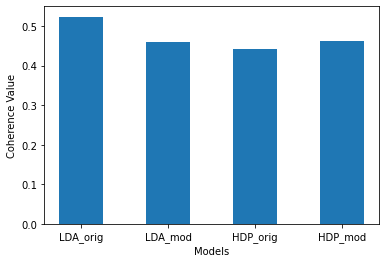

In [18]:
coherences = [coher_lda_orig, coher_lda_mod, coher_hdp_orig, coher_hdp_mod]
model_names = ['LDA_orig', 'LDA_mod', 'HDP_orig', 'HDP_mod']

evaluate_bar_graph(coherences, model_names)

### 5.2 What are the differences in topics for the two dataset versions?

### 5.3 Effect of data size and number of topics on perplexity and coherence scores

In [19]:
def effectOfDataAndK_LDA(datasets, datasetNames, K):
    print("K: ", K)
    print("total Tests: {} datasets * {} values of k = {}".format(str(len(datasets)), str(len(K)), 
                                                                  str(len(datasets) * len(K))))
    perplexityScores = {} 
    coherenceScores = {}
    for datasetName, papers in zip(datasetNames, datasets):
        print("running for dataset ", datasetName)
        data_prep, corpus, dictionary = preprocess(papers)
        
        perplexityForK = {}
        coherenceForK = {}
        for k in K:
            model = tm1(data_prep, k, corpus, dictionary)
            perp_score, coherence_lda = calculate_metrics_lda(data_prep, corpus, dictionary, model)
            
            print("For {} and k = {}: perplexity = {}, coherence = {}".format(datasetName, str(k), 
                                                                              str(perp_score), str(coherence_lda)))
            perplexityForK[str(k)] = perp_score
            coherenceForK[str(k)] = coherence_lda
            
        perplexityScores[datasetName] = perplexityForK
        coherenceScores[datasetName] = coherenceForK
        
    return perplexityScores, coherenceScores

In [20]:
def plot_perplexity(score, data_name):
    
    #plotting perplexity
    %matplotlib inline

    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    K = [i*3 for i in range(1, 11)]
    fig.tight_layout()

    #graph when N is same for all k
    for i in range(len(data_name)):
        perp_scoreDict = score[data_name[i]]
        perp_scores = []
        for numTopics in K:
            perp_scores.append(perp_scoreDict[str(numTopics)])
        
        axes[i].set_xticks(K)
        axes[i].plot(K, perp_scores)
        axes[i].set_xlabel("number of topics (k)")
        axes[i].set_ylabel("log_Perplexity")
        axes[i].set_title(data_name[i])

    plt.tight_layout()
    plt.show()

In [21]:
def plot_coherence(score, data_name):
    
    #plotting perplexity
    %matplotlib inline

    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    K = [i*3 for i in range(1, 11)]
    fig.tight_layout()

    #graph when N is same for all k
    for i in range(len(data_name)):
        coher_scoreDict = score[data_name[i]]
        coher_scores = []
        for numTopics in K:
            coher_scores.append(coher_scoreDict[str(numTopics)])
        
        axes[i].set_xticks(K)
        axes[i].plot(K, coher_scores)
        axes[i].set_xlabel("number of topics (k)")
        axes[i].set_ylabel("Coherence")
        axes[i].set_title(data_name[i])

    plt.tight_layout()
    plt.show()

#### 5.3.1 Making three datasets with 11998 (60%), 15998 (80%), and 19997(100%) documents

###### Randomly sampling papers

In [22]:
def sample(data, numSamples):
    randomSamples = random.sample(data, numSamples)
    return randomSamples

##### 5.3.1.1 LDA for `papers_orig`

In [23]:
data_original = load_dataset(ARCHIVE_NAME_ORIGINAL)

#sample the data
papers_orig_60 = sample(data_original, 11998)
papers_orig_80 = sample(data_original, 15998)
papers_orig_100 = data_original

Decompressing original.zip
Data is decompressed!


#### Checking the effect of change in 'k' and 'N'

In [ ]:
k = [i*3 for i in range(1, 11)]
datasets_paper_orig = [papers_orig_60, papers_orig_80, papers_orig_100]
datasetNames_orig = ["papers_orig_60", "papers_orig_80", "papers_orig_100"]
ldaperp_orig, ldacoher_orig = effectOfDataAndK_LDA(datasets_paper_orig, datasetNames_orig, k)

K:  [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
total Tests: 3 datasets * 10 values of k = 30
running for dataset  papers_orig_60


100%|██████████████████████████████████████████████████████████████████████████| 11997/11997 [00:01<00:00, 8271.58it/s]


Number of unique tokens: 3623
Number of documents - corpus size: 11997
For papers_orig_60 and k = 3: perplexity = -7.211666332333588, coherence = 0.6210010844275686
For papers_orig_60 and k = 6: perplexity = -7.2439904332563865, coherence = 0.5213020072361709
For papers_orig_60 and k = 9: perplexity = -7.249978540113618, coherence = 0.5388117704489039
For papers_orig_60 and k = 12: perplexity = -7.3604154127031425, coherence = 0.49838567574888687
For papers_orig_60 and k = 15: perplexity = -8.934581837026377, coherence = 0.5162520776763683
For papers_orig_60 and k = 18: perplexity = -9.303193624529916, coherence = 0.4735133045568129


In [ ]:
plot_perplexity(ldaperp_orig, datasetNames_orig)

In [ ]:
plot_coherence(ldacoher_orig, datasetNames_orig)

##### 5.3.1.2 LDA for `papers_mod`

In [19]:
data_modified = load_dataset(ARCHIVE_NAME_MODIFIED)

#sample the data
papers_mod_60 = sample(data_modified, 11998)
papers_mod_80 = sample(data_modified, 15998)
papers_mod_100 = data_modified

Decompressing modified.zip
Data is decompressed!


NameError: name 'sample' is not defined

In [ ]:
k = [i*3 for i in range(1, 11)]
datasets_paper_mod = [papers_mod_60, papers_mod_80, papers_mod_100]
datasetNames_mod = ["papers_mod_60", "papers_mod_80", "papers_mod_100"]
ldaperp_mod, ldacoher_mod = effectOfDataAndK_LDA(datasets_paper_mod, datasetNames_mod, k)

In [ ]:
plot_perplexity(perpScores_mod, datasetNames_mod)

In [ ]:
plot_coherence(coherScores_mod, datasetNames_mod)

##### 5.3.1.3 HDP for `papers_orig`

In [ ]:
def effectOfDataAndK_HDP(datasets, datasetNames, K):
    print("K: ", K)
    print("total Tests: {} datasets * {} values of k = {}".format(str(len(datasets)), str(len(K)), 
                                                                  str(len(datasets) * len(K))))
    coherenceScores = {}
    for datasetName, papers in zip(datasetNames, datasets):
        print("running for dataset ", datasetName)
        data_prep, corpus, dictionary = preprocess(papers)
        
        model = tm2(corpus, dictionary)
        hdptopics = [[term for term, wt in model.show_topic(n, topn=10)] for n in range(model.m_T)]
        
        coherenceForK = {}
        for k in K:            
            coherence_hdp = CoherenceModel(
                topics=hdptopics[:k], 
                texts=data_prep, 
                dictionary=dictionary).get_coherence()
            
            print("For {} and k = {}: coherence = {}".format(datasetName, str(k), str(coherence_hdp)))
            coherenceForK[str(k)] = coherence_hdp
            
        coherenceScores[datasetName] = coherenceForK
        
    return coherenceScores

In [ ]:
k = [i*3 for i in range(1, 11)]
datasets_paper_orig = [papers_orig_60, papers_orig_80, papers_orig_100]
datasetNames_orig = ["papers_orig_60", "papers_orig_80", "papers_orig_100"]
hdpcoher_orig = effectOfDataAndK_HDP(datasets_paper_orig, datasetNames_orig, k)

In [ ]:
plot_coherence(hdpcoher_orig, datasetNames_orig)

##### 5.3.1.4 HDP for `papers_mod`

In [ ]:
k = [i*3 for i in range(1, 11)]
datasets_paper_mod = [papers_mod_60, papers_mod_80, papers_mod_100]
datasetNames_mod = ["papers_mod_60", "papers_mod_80", "papers_mod_100"]
hdpcoher_mod = effectOfDataAndK_HDP(datasets_paper_mod, datasetNames_mod, k)

In [ ]:
plot_coherence(hdpcoher_mod, datasetNames_mod)

#### 5.3.2 Making three datasets with 500 000, 1 500 000, 2 500 000 sentences

In [ ]:
def getSentenceBasedCorpus(data, N):
    # M = 19997 for data_original
    # M = 18397 for data_modified
    #M samples will have N/M number of sentences from each sample
    #get sentences from the data
    
    sentences = [sent_tokenize(paper) for paper in data]
    n = int(N/len(sentences))
    sentenceData = ["".join(i[:n]) for i in sentences if len(i) != 0]
    
    return sentenceData

##### 5.3.2.1 LDA for `papers_orig`

In [ ]:
nltk.download('punkt')

sentences_500000_orig = getSentenceBasedCorpus(data_original, 500000)
sentences_1500000_orig = getSentenceBasedCorpus(data_original, 1500000)
sentences_2500000_orig = getSentenceBasedCorpus(data_original, 2500000)

In [ ]:
k = [i*3 for i in range(1, 11)]
datasets_sentence_orig = [sentences_500000_orig, sentences_1500000_orig, sentences_2500000_orig]
datasetNames_sent_orig = ["sent_orig_500000", "sent_orig_1500000", "sent_orig_2500000"]
ldaperp_sent_orig, ldacoher_sent_orig = effectOfDataAndK(datasets_sentence_orig, datasetNames_sent_orig, k)

In [ ]:
plot_perplexity(ldaperp_sent_orig, datasetNames_sent_orig)

In [ ]:
plot_coherence(ldacoher_sent_orig, datasetNames_sent_orig)

##### 5.3.2.2 LDA for `papers_mod`

In [ ]:
nltk.download('punkt')

sentences_500000_mod = getSentenceBasedCorpus(data_modified, 500000)
sentences_1500000_mod = getSentenceBasedCorpus(data_modified, 1500000)
sentences_2500000_mod = getSentenceBasedCorpus(data_modified, 2500000)

In [ ]:
k = [i*3 for i in range(1, 11)]
datasets_sentence_mod = [sentences_500000_mod, sentences_1500000_mod, sentences_2500000_mod]
datasetNames_sent_mod = ["sent_mod_500000", "sent_mod_1500000", "sent_mod_2500000"]
ldaperp_sent_mod, ldacoher_sent_mod = effectOfDataAndK(datasets_sentence_mod, datasetNames_sent_mod, k)

In [ ]:
plot_perplexity(ldaperp_sent_mod, datasetNames_sent_mod)

In [ ]:
plot_coherence(ldacoher_sent_mod, datasetNames_sent_mod)

##### 5.3.2.3 HDP for `papers_orig`

In [ ]:
k = [i*3 for i in range(1, 11)]
datasets_sentence_orig = [sentences_500000_orig, sentences_1500000_orig, sentences_2500000_orig]
datasetNames_sent_orig = ["sent_orig_500000", "sent_orig_1500000", "sent_orig_2500000"]
hdpcoher_sent_orig = effectOfDataAndK_HDP(datasets_sentence_orig, datasetNames_sent_orig, k)

In [ ]:
plot_coherence(hdpcoher_sent_orig, datasetNames_sent_orig)

##### 5.3.2.4 HDP for `papers_mod`

In [ ]:
k = [i*3 for i in range(1, 11)]
datasets_sentence_mod = [sentences_500000_mod, sentences_1500000_mod, sentences_2500000_mod]
datasetNames_sent_mod = ["sent_mod_500000", "sent_mod_1500000", "sent_mod_2500000"]
hdpcoher_sent_mod = effectOfDataAndK_HDP(datasets_sentence_mod, datasetNames_sent_mod, k)

In [ ]:
plot_coherence(hdpcoher_sent_mod, datasetNames_sent_mod)

## 6. Further improvements

In [ ]:
data_prep, corpus, dictionary = preprocess(papers)

# Set training parameters.
num_topics = 20
chunksize = 100
passes = 20
iterations = 1000
random_state = 0
alpha=[0.01, 0.05, 0.1, 0.25, 1.0, 5.0]
eta=[0.01, 0.05, 0.1]
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

for a in alpha:
    for b in eta:
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha=a,
            eta=b,
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            random_state=random_state,
            eval_every=eval_every
        )
        

In [ ]:
alpha = [0.01, 0.05, 0.1, 0.25, 1.0, 5.0]
eta = [0.01, 0.05, 0.1]